# Air Quality

[Data Source](https://archive.ics.uci.edu/ml/machine-learning-databases/00360/)  

## Contents
[Cleaning](#cleaning)  
[Exploratory Data Analysis](#eda)  
[Regression](#reg)

The data is from a gas sensor array that was placed at ground level in a highly polluted section of an unnamed Italian city. 

Several sensors were used in the detection of various pollutants. All various forms of metal oxides <sup>[1](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3264469/)</sup>

From these many sensors the question is whether or not a model could be built to predict the true levels of carbon monoxide present through the use of sensors that are attuned to other compounds. This would allow for the more robust installation of these sensor arrays that would still be versatile enough to detect the concentration of a specific compound. Additionally if it is found to have a relationship it could be used to determine if the values of a sensor are within an acceptable range. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='white')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='cleaning'></a>

In [61]:
air_quality = pd.read_csv('AirQualityUCI/AirQualityUCI.csv', delimiter=';') # ';' was delimiter rather than ','

In [62]:
air_quality.head(2)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN


In [4]:
print air_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
Date             9357 non-null object
Time             9357 non-null object
CO(GT)           9357 non-null object
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null float64
C6H6(GT)         9357 non-null object
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null object
RH               9357 non-null object
AH               9357 non-null object
Unnamed: 15      0 non-null float64
Unnamed: 16      0 non-null float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB
None


Just from looking at the first few rows in the dataframe there are a few issues. The data for some of the columns has been recorded in the european style of commas instead of periods to indicate the decimals. Causing them to appear as objects, rather than numeric values (float64). The last two columns contain no information.

The info function is useful in that it shows the number of entries, how many contain a value, and what the type of that value is. It is useful to find NaNs, but does have weaknesses. If non existent values were filled using a number (i.e. -9999) it will not be counted. In order to be certain the data is as desired it will be worthwhile to go through a few more checks to make certain that the data is in the correct format and contains relevant information.

From the dtypes listed Unnamed 15 and 16 columns can be dropped. This will leave the following data for analysis:

||Name|Explination|Data Type|
|-|-|-|-|
|1|Date|Date of Measurement DD/MM/YYYY|Datetime|
|2|Time|Time Measurement was Taken|Datetime|
|3|CO(GT)|Ground Truth Carbon Monoxide Presence| Float|
|4|PT08.S1(CO)| Tin Oxide Hourly Average Sensor Response - CO target|Float| 
|5|NMHC(GT)|Ground Truth Hourly Average Non Metanic Hydrocarbons(NMHC)|Float|
|6|C6H6(GT)|Ground Truth Benzene|Float|
|7|PT08.S2(NMHC)|Titania sensor response - NMHC Targeted|Float|
|8|NOx(GT)|Ground Truth Nitrogen Dioxide|Float|
|9|PT08.S3(NOx)|Tungsten Oxide Nitrogen Oxides Targeted|Float|
|10|NO2(GT)|Ground Truth Nitrogen Dioxide|Float|
|11|PT08.S4(NO2)|Tungsten Oxide Response Nitrogen Dioxide Targeted|Float
|12|PT08.S5(O3)|Indium Oxide Response Ozone Targeted|Float| 
|13|T|Temperature (°C)|Float|
|14|RH|Relative Humidity|Float|
|15|AH|Absolute Humidity|Float|


Ground truth specifies that this reading was the true value, taken from a reference certified analytic device that was placed in the vincinity of the sensor array. The units for all ground truth readings were in $\frac{mg}{m^3}$. 

Measurements were taken each hour. The experiment ran for a little more than a year, starting March 10th, 2004 to April 4th, 2005

Non-existent values were given the value of -200. These will be replaced by NaNs for further analysis, and dropped accordingly.

Below a mask was created in order to drop the unnamed columns from the dataframe. The returned dataframe was then assigned to a new variable in order to not have to worry about reassigning values.

In [63]:
mask = [x for x in air_quality.columns if x not in ["Unnamed: 15", "Unnamed: 16"]]

In [64]:
air = air_quality[mask]

Now to remove all NaNs that occupy entire rows and also replace values of -200 with NaN

In [33]:
for column in air.columns:
    # Commas present only as string, before converting to numeric replace with decimals
    air[column] = air[column].apply(lambda x: x.replace(',','.') if type(x)==str else x)
    
air = air.dropna(how='all')

for column in air.columns:
        air[column] = air[column].apply(lambda x: np.NaN 
                                    if x == '-200' or x == -200 # If item is present as string or integer
                                    else x)

Again another mask needs to be created to specify which columns need to be converted to numeric values and which ones do not. The Time and Date columns are not of great concern for this analysis, but they would be converted to datetime.

In [9]:
to_nums =[x for x in air.columns if x not in ['Date', 'Time']]

In [10]:
air[to_nums] = air[to_nums].applymap(float) # Apply float to all needed columns

In [34]:
air.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.000000,8991.000000,914.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.453252,217.080037,204.459921,7.449820,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288,8.832116,17.316892,0.403813
min,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


After all of the cleaning has been successfully completed it is possible to move on to the analysis portion of the project. 

In [35]:
air_ = air[[column for column in air.columns 
            if u'(GT)' not in column or column == u"CO(GT)"]] # New dataframe with columns for analysis

air_ = air_.dropna(how='any')

# EDA
<a id='eda'></a>
For the desired analysis, will need to remove the present ground truths for all of the chemical species except for carbon monoxide.  
To hone it down even further a correlation plot can show how related the variables are to each other 

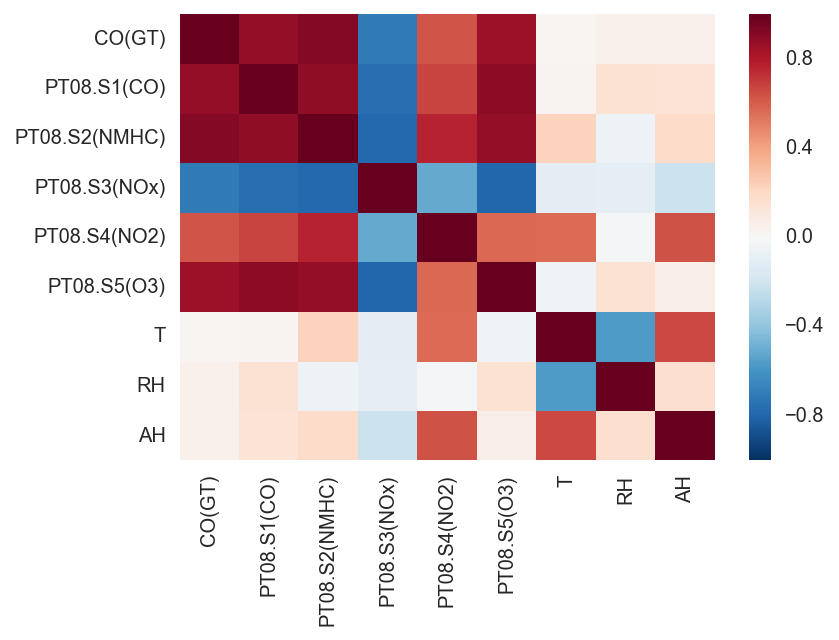

In [37]:
sns.heatmap(air_.corr())
plt.show()

It would appear that there is a strong correlation between the Carbon Monoxide levels and the sensors for all of the available species, all positive, except for the nitrogen oxide species which are negatively correlated. Time and absolute humidity have a weak correlation and the relative humidity does not appear to have any effect on the carbon monoxide levels.  
A pairplot with a regression focus helps confirm the assumption 

In [15]:
sensors = [sensor for sensor in air_.columns if sensor not in ['Date', 'Time', 'T', 'RH', 'CO(GT)', 'PT08.S1(CO)']]

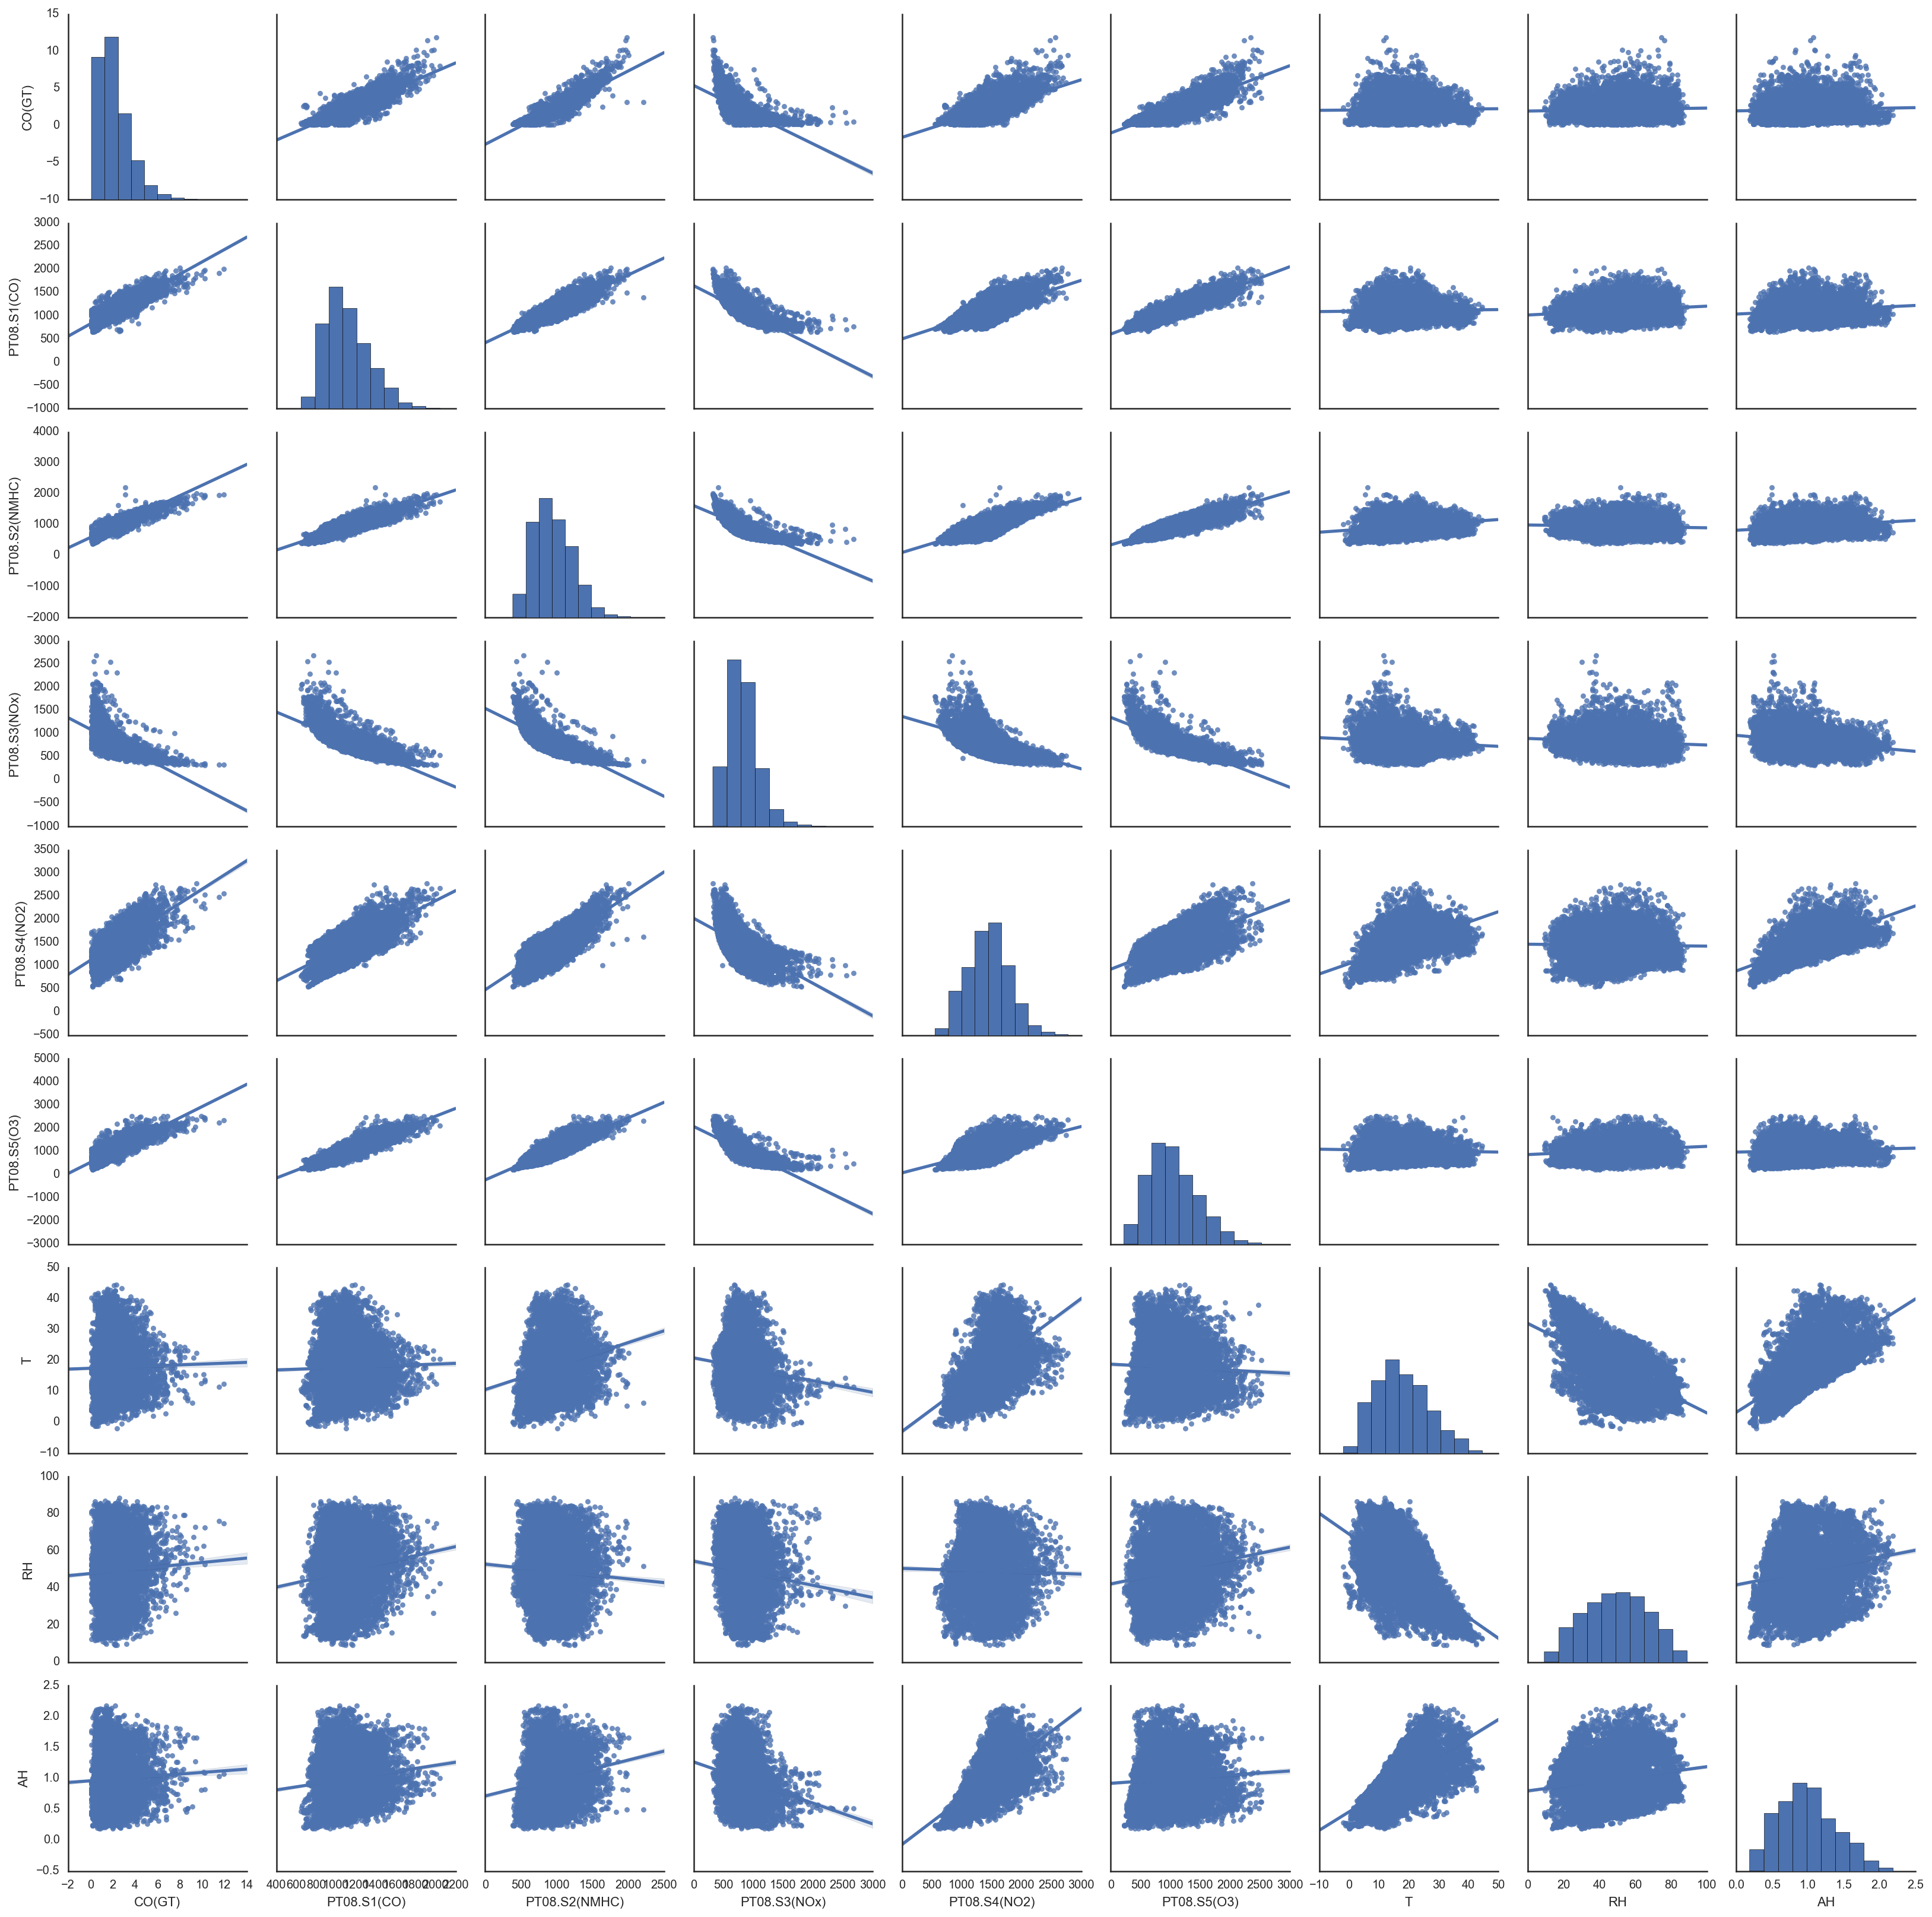

In [38]:
sns.pairplot(air_.dropna(how='any'), kind='reg')
plt.show()

<a id='reg'></a>
# Regression
From above it would appear that the NOx species relative to carbon monoxide has a non linear appearance. Other than that the chemical sensors present have a linear relationship to the ground truth of carbon monoxide.

The information can then be used to construct the linear models. The models can then be verified through both the use of a train test split to introduce unknown data to the model to see how resilient it is to overfitting. 

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

Y = air_['CO(GT)']
X = air_[sensors]

In [40]:
X.columns

Index([u'PT08.S2(NMHC)', u'PT08.S3(NOx)', u'PT08.S4(NO2)', u'PT08.S5(O3)',
       u'AH'],
      dtype='object')

In [41]:
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=11)

In [42]:
lin_reg = LinearRegression()

In [43]:
lin_reg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [44]:
y_pred = lin_reg.predict(x_test)

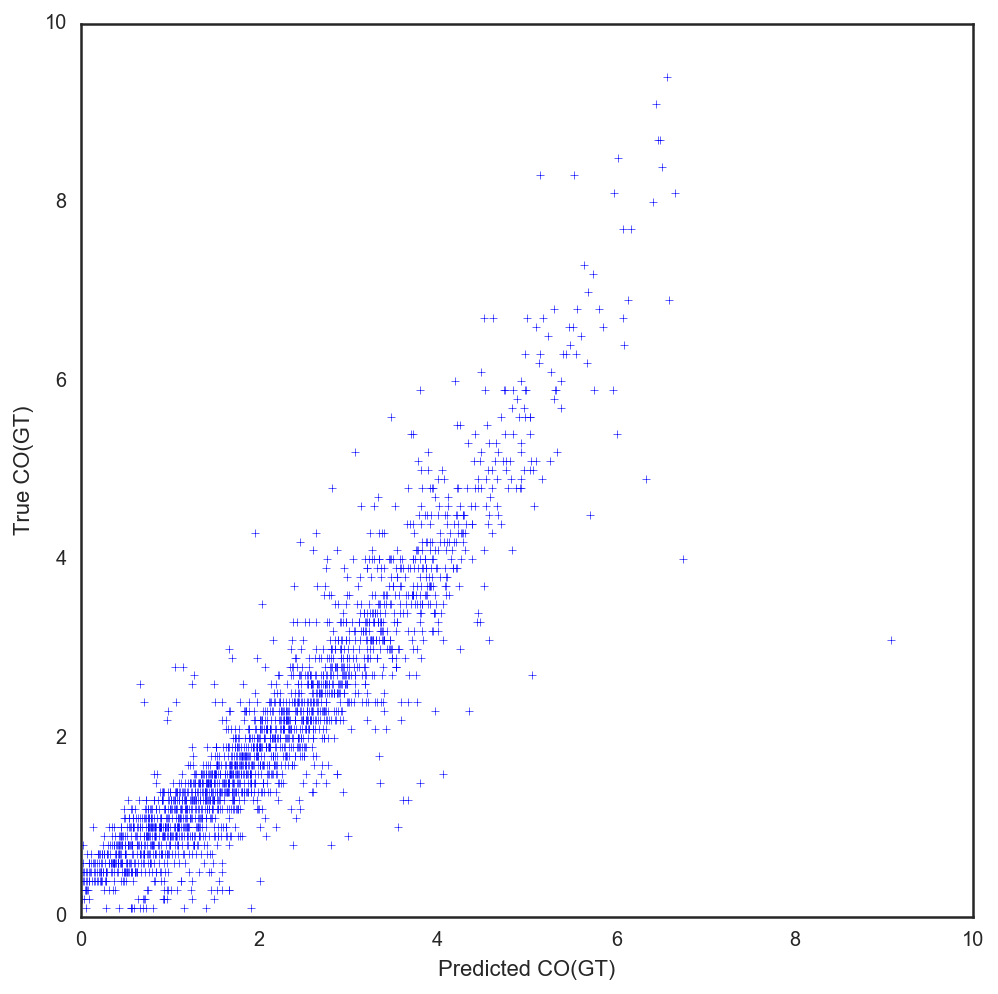

In [60]:
plt.figure(figsize=(8,8))
plt.scatter(y_pred, y_test, marker='+')
plt.xlabel("Predicted CO(GT)")
plt.xlim(0,10)
plt.ylim(0,10)
plt.ylabel("True CO(GT)")
plt.show()

In [46]:
lin_reg.score(x_test, y_test)

0.85189650526074745

This is a satisfactory $r^2$ value for this situation. In the physical sciences typically an $r^2$ in the 0.75 to 0.9 range is acceptable. Because of linear regression containing that irreducible errors that are caused by the 

An $r^2$ value of more than 0.9 is always something that causes a high degree of overfitting of the model. If new data were entered, it would likely be found to be very  

Using sklearn is useful for visualizing the outcome of the model versus the truth, but in this case it would also be useful to perform the same analysis in another libarary, statsmodels, to get a clearer picture of the influence of these variables upon the output. 

In [51]:
import statsmodels.api as sm

X = sm.add_constant(X) # Add intercept

In [52]:
model = sm.OLS(Y,X)

In [53]:
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                 CO(GT)   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     9368.
Date:                Wed, 20 Jul 2016   Prob (F-statistic):               0.00
Time:                        15:22:11   Log-Likelihood:                -5738.9
No. Observations:                7344   AIC:                         1.149e+04
Df Residuals:                    7338   BIC:                         1.153e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const            -3.0186      0.075    -40.370

From the work done above it would be appropriate to use the other sensors either to disregard outliers due to suspicious reponse, or to build sensor arrays with limited sensors. This would be very useful in urban situations where pollutants originate from common recurring sources.